# Optimal parade route

# Topic references
- [Iterated weighted $\ell_1$ heuristic](http://stanford.edu/class/ee364b/lectures/l1_ext_slides.pdf)

# Problem statement

In this notebook, we'll tackle the problem of trying to protect a parade route by placing a limited number of guards.

The parade route is discritized into $m$ points. There are $n$ possible guard locations with associated decision variable $x \in 
\lbrace 0,1\rbrace^n$, where $x_i = 1$ if and only if a guard is placed at location $i$. Associated with guard location $i$ is a *coverage vector* $a_i \in \mathbf{R}^m$, which describes how well a guard placed at location $i$ would 'cover' each point in the parade route. We will assume that guard coverage is additive, so that the vector describing the total coverage of every edge is given by $Ax$, where $A \in \mathbf{R}^{m \times n}$ has $a_i$ as its $i$ th column.

The parade route is only as secure as its least well-covered point. Our goal is to place $k$ guards to maximize the minimum coverage over the points in the route.

# Optimization formulation

We can formulate this as the optimization problem as follows, the constraint $t1 \leq Ax$ means that every row of A @ x
should larger or equal to t, which is a tolerance to learn.

\\[
$$
\begin{array}{ll}
  \text{maximize} & t \\
  \text{subject to} & t1 \leq Ax\\
  & x \in \lbrace 0,1 \rbrace^n \\
  & \mathbf{1}^Tx = k.
\end{array}
$$
\\]

This problem is nonconvex and, in general, NP-hard due to the Boolean decision variable.

# Relaxation

We can try to approach the problem with convex optimization by first forming the convex relaxation

\\[
$$
\begin{array}{ll}
  \text{maximize} & t \\
  \text{subject to} & t1 \leq Ax\\
  & 0 \leq x \leq 1 \\
  & \mathbf{1}^Tx = k,
\end{array}
$$
\\]
by constraining $x \in [0,1]^n$.

In general, the solution to this problem, $x^\star$, will have fractional values. As we want a Boolean allocation, we can use an [iterated weighted $\ell_1$ heuristic](http://stanford.edu/class/ee364b/lectures/l1_ext_slides.pdf) to try to recover a Boolean solution.

# Iterated weighted $\ell_1$ heuristic

To try and recover a Boolean solution, we will solve a sequence of convex problems where we add a linear term $-w^Tx$ to the objective, picking the weight vector $w \in \mathbf{R}^n_+$ at each iteration to try and induce a sparse solution vector $x^\star$. The details can be found in the [Stanford EE364B lecture notes](http://stanford.edu/class/ee364b/lectures/l1_ext_slides.pdf).

The algorithm consists of initializing $w = 0$ and repeating the two steps

1. \\[
\begin{array}{ll}
  \text{maximize} & t  - w^Tx\\
  \text{subject to} & t \leq Ax\\
  & 0 \leq x \leq 1 \\
  & \mathbf{1}^Tx = k,
\end{array}
\\]
2. Let $w_i = \alpha/(\tau + x_i) \forall i$

until we reach a Boolean solution. Here, $\alpha$ and $\tau$ are adjusted to promote a sparse solution. Typical choices would be $\alpha = 1$ and $\tau = 10^{-4}$.

Intuitively, the weight vector $w$ is incentivizing elements of $x$ which were close to zero in the last iteration towards zero in the next iteration.

# Example

We create a parade route in the unit square $[0,1] \times [0,1]$ by generating points along a connected sequence of line segments. Possible guard locations are a set of randomly placed points in the unit square. Guards' coverage of points in the parade route is a function of distance between the two points. We also add buildings in the unit square to obstruct the guards' view. The guard has no effect on a point if his line of sight is obstructed. We generate the $A$ matrix for this problem instance below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

def form_path(points,n):
    x, y = [], []
    pold = points[0]
    for p in points[1:]:
        x += list(np.linspace(pold[0],p[0],n))
        y += list(np.linspace(pold[1],p[1],n))
        pold = p

    path = np.array([x,y]).T
    return path

def form_grid(k):
    xs = list(np.linspace(0,1,k))
    ys = list(np.linspace(0,1,k))

    locations = []
    for x in xs:
        for y in ys:
            locations.append(np.array((x,y)))
    return np.array(locations).T

def guard_sets(k,num,noise):
    guard_set = []
    grid = form_grid(k)
    for i in range(num):
        pert = noise*np.random.randn(*grid.shape)
        guard_set.append( grid+pert )
    return np.hstack(guard_set)

def inRect(p,rect):
    x,y,w,h = rect
    return x <= p[0] and p[0] <= x + w and y <= p[1] and p[1] <= y + h

def remove_guards(guards,buildings):
    '''Remove guards inside buildings and outside unit square.'''
    outside = []
    for i, guard in enumerate(guards.T):
        inside = False
        for build in buildings:
            if inRect(guard,build):
                inside = True
                break
            if not inRect(guard,(0,0,1,1)):
                inside = True
                break
        if not inside:
            outside.append(i)
    
    return guards[:,outside]

def intersect(p1,p2,xmin,xmax,ymin,ymax):
    '''determine if a rectangle given by xy limits blocks the line of sight between p1 and p2'''

    block = False
    
    # if either point inside block
    for p in [p1,p1]:
        if xmin <= p[0] and p[0] <= xmax and ymin <= p[1] and p[1] <= ymax:
            return True
    
    # if the two points are equal at this stage, then they are outside the block
    if p1[0] == p2[0] and p1[1] == p2[1]:
        return False
    
    
    if p2[0] != p1[0]:
        for x in [xmin,xmax]:
            alpha = (x-p1[0])/(p2[0] - p1[0])
            y = p1[1] + alpha*(p2[1] - p1[1])

            if 0 <= alpha and alpha <= 1 and ymin <= y and y <= ymax:
                return True
            
    if p2[1] != p1[1]:
        for y in [ymin,ymax]:
            alpha = (y-p1[1])/(p2[1] - p1[1])
            x = p1[0] + alpha*(p2[0] - p1[0])

            if 0 <= alpha and alpha <= 1 and xmin <= x and x <= xmax:
                return True
        
    return False

def p_evade(x,y,r=.5,minval=.1):
    d = np.linalg.norm(x-y)
    if d > r:
        return 1
    return (1-minval)*d/r + minval

# 获取guard的效果矩阵，其中1-log Aij表示在j位置摆放guard对path_i的效果
# Aij在[0.1,1]之间，所以1-log0.1是最大的增益值
# 如果guard和path_i被building挡住了增益效果就是0，否则增益效果根据距离计算，距离越近增益越大
def get_guard_effects(path, guards, buildings, evade_func):
    guard_effects = []
    for guard in guards.T:
        guard_effect = []
        for p in path:
            prob = 1
            if not np.any([intersect(p,guard,x,x+w,y,y+h) for x,y,w,h in buildings]):
                prob = evade_func(p,guard)
            guard_effect.append(prob)
        guard_effects.append(guard_effect)
    return np.array(guard_effects).T

    locations = []
    for x in xs:
        for y in ys:
            point = np.array((x,y))
            detect_p = []
            for r in path:
                detect_p.append(p_evade(point,r,r=.5,m=0))
            locations.append((point,np.array(detect_p)))

(150, 324)
[[2.66183211 2.1660306  1.917638   1.46012684 1.345877  ]
 [2.93425487 2.32476464 2.04847544 1.54263954 1.41910099]
 [3.03973799 2.49842792 2.19740253 1.63257418 1.49810096]
 [2.77514864 2.66414556 2.36866335 1.73139788 1.5838635 ]
 [2.52675429 2.73936868 2.56472568 1.84106027 1.67765018]]


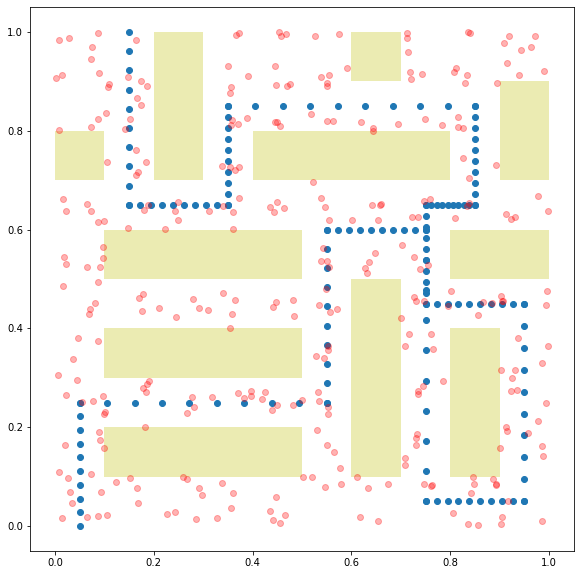

In [8]:
np.random.seed(0)

buildings = [(.1,.1,.4,.1),
             (.6,.1,.1,.4),
             (.1,.3,.4,.1),
             (.1,.5,.4,.1),
             (.4,.7,.4,.1),
             (.8,.1,.1,.3),
             (.8,.5,.2,.1),
             (.2,.7,.1,.3),
             (.0,.7,.1,.1),
             (.6,.9,.1,.1),
             (.9,.7,.1,.2)]

n = 10

points = [(.05,0),(.05,.25),(.55,.25),(.55,.6),(.75,.6),(.75,.05),(.95,.05), (.95,.45),(.75,.45), (.75,.65),(.85,.65),
          (.85,.85),(.35,.85),(.35,.65),(.15,.65),(.15,1)]

path = form_path(points,n)

g = guard_sets(12,4,.02)
g = remove_guards(g,buildings)

guard_effects = get_guard_effects(path, g, buildings, p_evade)

A = 1 - np.log(guard_effects)

print(A.shape)
print(A[:5,:5])

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,aspect='equal')
for x,y,w,h in buildings:
    rect = plt.Rectangle((x,y),w,h,fc='y',alpha=.3)
    ax.add_patch(rect)

ax.plot(path[:,0],path[:,1],'o')

ax.plot(g[0,:],g[1,:],'ro',alpha=.3)

We perform the iterative algorithm below. At each step, we plot the vector $x$, demonstrating that it becomes increasingly sparse at each iteration.

final objective value: -12.656499947336863


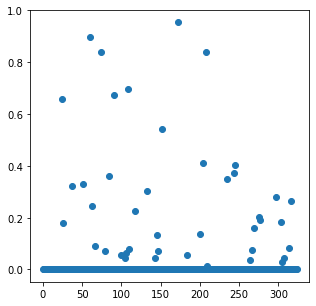

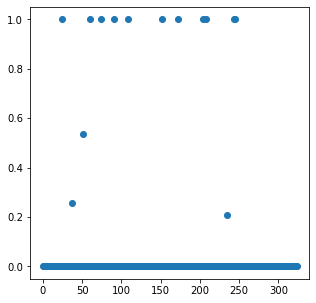

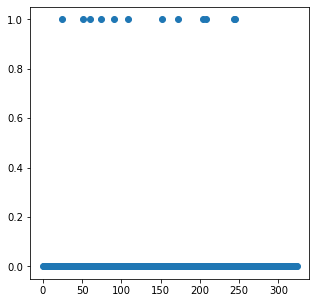

In [9]:
num_guards = 12
tau = 1e-2

m,n = A.shape

# 设置w=0，迭代之后很快x将会趋向于{0,1}
w = np.zeros(n)

for i in range(3):
    x = cp.Variable(shape=n)
    t = cp.Variable(shape=1)

    objective = cp.Maximize(t - x.T @ w)
    constr = [0 <=x, x <= 1, t <= A @ x, cp.sum(x) == num_guards]
    cp.Problem(objective, constr).solve(verbose=False)
    x = np.array(x.value).flatten()
    w = 2/(tau+np.abs(x))
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.plot(x,'o')

xsol = x
print("final objective value: {}".format(objective.value))

Below, we plot the final Boolean allocation. The blue dots represent the parade route. The red dots represent the possible guard placement locations. The green dots show the actual guard placements. Yellow rectangles are buildings which obstruct the guards' view.

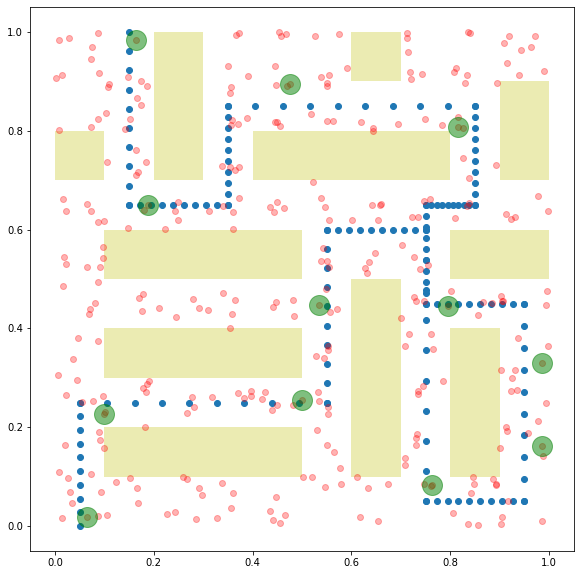

In [10]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,aspect='equal')
for x,y,w,h in buildings:
    rect = plt.Rectangle((x,y), w, h, fc='y', alpha=.3)
    ax.add_patch(rect)

ax.plot(path[:,0], path[:,1], 'o')

ax.plot(g[0,:], g[1,:], 'ro', alpha=.3)
ax.plot(g[0,xsol > .5], g[1,xsol > .5], 'go', markersize=20, alpha=.5)